In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='7'

In [2]:
from transformers import AutoTokenizer, AutoProcessor,Qwen2VLForConditionalGeneration
import torch
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto",output_attentions=True
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

/home/sarmistha/miniconda3/envs/smol/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

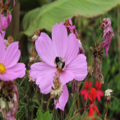

In [3]:
import requests
from PIL import Image
from io import BytesIO

# URL of the image
image_url = "https://huggingface.co/spaces/merve/chameleon-7b/resolve/main/bee.jpg"

# Download the image
response = requests.get(image_url)
if response.status_code == 200:
    img = Image.open(BytesIO(response.content))

    # Resize to 256x256
    img_resized = img.resize((120, 120))

img_resized


In [4]:
# !pip install qwen-vl-utils


In [5]:
from qwen_vl_utils import process_vision_info
messages = [
    {
        "role": "user",
        "content": [
            # {
            #     "type": "video",
            #     "video": '../videos/DD9AynYR0WgdqJiw.mp4'#'R12ZN5OFE1SZFF.mp4'#'../videos/DD9AynYR0WgdqJiw.mp4'#img_resized#"bee_resized.jpg",
            # },
            {
                "type": "image",
                "image": img_resized#"bee_resized.jpg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)

inputs = processor(
    text=[text],
    images=[image_inputs],
    #videos=[video_inputs1,video_inputs1],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")


In [6]:
img_tok_idx = []

for idx,tok in enumerate(inputs['input_ids'][0]):
    if tok in [151652, 151653,151654, 151655,151656]:
        img_tok_idx.append(idx)

len(img_tok_idx)


18

In [7]:
outputs = model(**inputs)


Qwen2VLModel is using Qwen2VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
The attention layers in this model are transitioning from computing the RoPE embeddings internally through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed `position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be removed and `position_embeddings` will be mandatory.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

def visualize_attention_maps(attention_maps):
    num_layers = len(attention_maps)
    num_heads = attention_maps[0].shape[1]
    seq_len = attention_maps[0].shape[2]

    def visualize(layer_idx, head_idx):
        attn_map = attention_maps[layer_idx][0, head_idx].detach().to(torch.float16).cpu().numpy()
        mask = np.triu(np.ones_like(attn_map), k=1)
        plt.figure(figsize=(15, 7))
        plt.subplot(1, 2, 2)
        masked_attn_map = np.ma.masked_where(mask == 1, attn_map)
        plt.imshow(masked_attn_map, cmap="viridis", interpolation="nearest")
        plt.colorbar(label="Attention Score")
        plt.xlabel("Key Position")
        plt.ylabel("Query Position")
        plt.title(f"Attention Map (Lower Triangle) - Layer {layer_idx}, Head {head_idx}")
        plt.tight_layout()
        plt.show()

    interact(visualize, layer_idx=(0, num_layers - 1), head_idx=(0, num_heads - 1))

visualize_attention_maps(outputs.attentions)

interactive(children=(IntSlider(value=13, description='layer_idx', max=27), IntSlider(value=5, description='he…

In [10]:
def visualize_l2_norms(past_key_values):
    past_keys = [kv[0] for kv in past_key_values]
    num_layers = len(past_keys)
    num_heads = past_keys[0].shape[1]
    seq_len = past_keys[0].shape[2]

    l2_norms = np.zeros((num_layers, num_heads, seq_len))
    for layer in range(num_layers):
        keys = past_keys[layer]
        l2_norms[layer] = torch.norm(keys, p=2, dim=3).squeeze(0).detach().to(torch.float16).cpu().numpy()

    def plot_l2_norm(layer_idx, head_idx):
        plt.figure(figsize=(15, 7))
        plt.plot(range(seq_len), l2_norms[layer_idx, head_idx], marker="o", linestyle="-")
        plt.xlabel("Sequence Position")
        plt.ylabel("L2 Norm")
        plt.title(f"L2 Norm of Past Keys - Layer {layer_idx}, Head {head_idx}")
        plt.grid(True)
        plt.show()

    interact(plot_l2_norm, layer_idx=(0, num_layers-1), head_idx=(0, num_heads-1))

visualize_l2_norms(outputs.past_key_values)


interactive(children=(IntSlider(value=13, description='layer_idx', max=27), IntSlider(value=0, description='he…